### Данные взяты с [МТС Geohack.112](https://datasouls.com/c/mts-geohack/description)

##  Постановка задачи: предсказывание среднего числа звонков в службы в 112
## Метрика качества: [Kendall rank correlation coefficient](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

### Будем решать, как задачу регрессии.

In [68]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import collections 
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GroupKFold, cross_val_predict
import lightgbm as lgb
from scipy.stats import kendalltau,boxcox
import warnings

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor, LGBMRanker

import seaborn as sns

import pickle
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
import collections
import osmread

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
%matplotlib inline

np.random.seed(1)

In [7]:
#Coordinates of the Kremlin
kremlin_lat, kremlin_lon = 55.753722, 37.620657

In [8]:
#Inverse Box-Cox transformation
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [10]:
df_zones = pd.read_csv('data/zones.csv', index_col='zone_id')
df_zones.head()

,lat_bl,lon_bl,lat_tr,lon_tr,lat_c,lon_c,is_test,is_target,calls_daily,calls_workday,calls_weekend,calls_wd0,calls_wd1,calls_wd2,calls_wd3,calls_wd4,calls_wd5,calls_wd6
zone_id,,,,,,,,,,,,,,,,,,
0,55.378220,36.999105,55.382744,37.007050,55.380482,37.003077,0,0.0,0.002177,0.001325,0.004213,0.003006,0.000000e+00,6.885802e-04,0.003006,0.000000e+00,0.001374,0.007052
1,55.378252,37.006994,55.382775,37.014938,55.380514,37.010966,0,0.0,0.000996,0.000535,0.002096,0.000765,0.000000e+00,1.176913e-03,0.000765,0.000000e+00,0.001374,0.002818
2,55.378284,37.014883,55.382806,37.022827,55.380545,37.018855,0,0.0,0.001284,0.000724,0.002622,0.001322,0.000000e+00,1.020885e-03,0.001322,0.000000e+00,0.001374,0.003871
3,55.378315,37.022772,55.382837,37.030715,55.380576,37.026744,0,0.0,0.000968,0.000476,0.002143,0.000815,0.000000e+00,7.802124e-04,0.000815,0.000000e+00,0.001374,0.002912
4,55.378345,37.030662,55.382867,37.038603,55.380606,37.034633,0,0.0,0.000842,0.000310,0.002113,0.000783,1.821651e-07,7.286604e-07,0.000782,8.602241e-07,0.001374,0.002851


In [12]:
tagged_nodes = pickle.load(open('osm/tagged_nodes.pickle', 'rb'))

**Источники данных для построения модели**

## Статистика по пожарам 

Взята с сайта [МЧС России](https://moscow.mchs.ru/document/1316565) по Москве.

Колонки представляют собой статистику по количеству пожаров в 2017 и 2016 году ($fiers2017$, $fiers2016$), количество смертей от пожаров ($deaths$), травм ($injuries$), спасённых человек ($saved$), материальный ущерб ($damage$), количество загораний ($zagoraniya$), удельные значения на 100 тыс человек, население ($population$). $lat_c$, $lon_c$ - широта и долгота середины района (субъективная оценка). 

In [5]:
fiers = pd.read_csv('./additional_data/fiers_area.csv')
print('Shape:', fiers.shape)
fiers.head()

Shape: (146, 26)


,AO,area,lat_c,lon_c,fiers2017,fiers2016,deaths2017,deaths2016,injuries2017,injuries2016,...,zagoraniya2017,zagoraniya2016,fiers2017_100k,fiers2016_100k,deaths2017_100k,deaths2016_100k,injuries2017_100k,injuries2016_100k,population2017,population2016
0,Центральный АО,Арбат,55.751066,37.574420,36.0,35.0,1.0,NaN,3.0,NaN,...,3.0,2.0,104.66,102.90,8.72,NaN,197.29,5.86,34396.0,34012.0
1,Центральный АО,Басманный,55.766543,37.635249,80.0,83.0,2.0,1.0,7.0,9.0,...,36.0,28.0,72.67,75.43,6.36,8.18,0.57,7.68,110083.0,110042.0
2,Центральный АО,Замоскворечье,55.734974,37.616885,35.0,74.0,NaN,NaN,1.0,1.0,...,NaN,1.0,60.48,128.20,1.73,1.73,112.34,175.31,57871.0,57722.0
3,Центральный АО,Красносельский,55.776518,37.640349,36.0,34.0,NaN,NaN,3.0,3.0,...,14.0,11.0,74.27,70.36,6.19,6.21,NaN,10.66,48474.0,48324.0
4,Центральный АО,Мещанский,55.778231,37.611418,23.0,40.0,NaN,NaN,1.0,5.0,...,15.0,14.0,38.26,66.65,1.66,8.33,0.31,3.43,60121.0,60014.0


## Статистика ДТП

Вся статистика по ДТП в Москве взята с сайта [Госавтоинспекции](http://stat.gibdd.ru/) (вкладка "Выгрузка показателей БДД" -> "Карточки ДТП" -> "Дорожно-транспортные происшествия"). $lat_c$, $lon_c$ - широта и долгота середины района (субъективная оценка). 

In [6]:
accidents = pd.read_csv('./additional_data/accidents.csv')
print('Shape:', accidents.shape)
accidents.head()

Shape: (125, 7)


,area,lat_c,lon_c,Погибло,Ранено,Кол-во ТС,Кол-во участников
0,Алексеевский,55.811254,37.617419,0.0,15.0,25.0,35.0
1,Алтуфьевский,55.879000,37.569239,0.0,10.0,15.0,20.0
2,Арбат,55.751066,37.574420,10.0,20.0,35.0,60.0
3,Аэропорт,55.800686,37.524482,0.0,30.0,35.0,60.0
4,Бабушкинский,55.866964,37.644678,5.0,35.0,75.0,95.0


## Статистика по преступлениям 

Статистика взята с [сайта прокуратуры Москвы](http://www.mosproc.ru/statistics/). Период - за январь-декабрь 2017. $lat_c$, $lon_c$ - широта и долгота середины административного округа (субъективная оценка). $crimes$ - количества преступления, совершенные женщинами и мужчинами соответственно. 

In [7]:
crimes = pd.read_csv('./additional_data/crimes.csv')
print('Shape:', crimes.shape)
crimes.head()

Shape: (11, 5)


,AO,lat_c,lon_c,crimes_woman,crimes_man
0,Центральный АО,55.7568,37.6191,868.0,4050.0
1,Северо-Восточный АО,55.8574,37.6230,623.0,3293.0
2,Восточный АО,55.7922,37.7871,970.0,4571.0
3,Юго-Восточный АО,55.6929,37.7693,597.0,3411.0
4,Южный АО,55.6383,37.6553,813.0,3595.0


In [8]:
# введем дополнительные фичи - общее количество преступлений и удельные показатели преступности 
population_AO_2017 = fiers[['AO','population2017']].groupby('AO').agg('sum').reset_index()
crimes = pd.merge(crimes, population_AO_2017, how='left', on='AO')
crimes['crimes_tot'] = crimes['crimes_man'] + crimes['crimes_woman']
crimes['crimes_woman_spec'] = crimes['crimes_woman'] / crimes['population2017']
crimes['crimes_man_spec'] = crimes['crimes_man'] / crimes['population2017']
crimes['crimes_tot_spec'] = crimes['crimes_tot'] / crimes['population2017']

In [9]:
crimes.head()

,AO,lat_c,lon_c,crimes_woman,crimes_man,population2017,crimes_tot,crimes_woman_spec,crimes_man_spec,crimes_tot_spec
0,Центральный АО,55.7568,37.6191,868.0,4050.0,769630.0,4918.0,0.001128,0.005262,0.006390
1,Северо-Восточный АО,55.8574,37.6230,623.0,3293.0,1415283.0,3916.0,0.000440,0.002327,0.002767
2,Восточный АО,55.7922,37.7871,970.0,4571.0,1507198.0,5541.0,0.000644,0.003033,0.003676
3,Юго-Восточный АО,55.6929,37.7693,597.0,3411.0,1385385.0,4008.0,0.000431,0.002462,0.002893
4,Южный АО,55.6383,37.6553,813.0,3595.0,1624339.0,4408.0,0.000501,0.002213,0.002714


### Данные Raiffeisen Data Cup

В данных конкурса Raiffeisen Data Cup (https://boosters.pro/champ_11) представлены транзакции клиентов. Считаны данные и преобразованы, объедены train и test, выделены транзакции по дням недели (пригодится для прогноза звонков по конкретным дням недели), адреса работы и дома, транзакции по mcc кодам.

In [ ]:
pd_test_set_boosters = pd.read_csv('data/test_set_boosters.csv')
pd_test_set_boosters['mcc'] = pd_test_set_boosters['mcc'].apply(lambda x: int(x.replace(',', '')) 
                                                                          if type(x) is str else x)
pd_train_set_boosters = pd.read_csv('data/train_set_boosters.csv')
pd_train_set_boosters['pos_address_lat'] = pd_train_set_boosters['pos_adress_lat']
pd_train_set_boosters['pos_address_lon'] = pd_train_set_boosters['pos_adress_lon']

pd_train_set_boosters = pd.concat([pd_train_set_boosters, pd_test_set_boosters])
pd_train_set_boosters['amount'] = pd_train_set_boosters.amount.apply(lambda x: 10**x)
pd_train_set_boosters = pd_train_set_boosters[pd_train_set_boosters.pos_address_lat.notnull()]


In [ ]:
pd_boosters_transactions_coords = pd_train_set_boosters[['pos_address_lat', 'pos_address_lon']].values

pd_train_set_boosters['transaction_date'] = pd.to_datetime(pd_train_set_boosters.transaction_date)

pd_train_set_boosters['transaction_date_weekday'] = pd_train_set_boosters['transaction_date'].apply(lambda x: x.weekday())
dict_weekday_pd_boosters_transactions_coords = dict()
for i in range(7):
    dict_weekday_pd_boosters_transactions_coords[i] = \
        pd_train_set_boosters[pd_train_set_boosters['transaction_date_weekday'] == i]\
                                                   [['pos_address_lat', 'pos_address_lon']].values
            
mcc_top_range = [5411, 5814, 5541, 5812, 5912, 4111, 5499, 5691, 5977, 5921]

dict_mcc_boosters_transactions_coords = dict()
for mcc in mcc_top_range:
    pd_mcc = pd_train_set_boosters[pd_train_set_boosters['mcc'] == mcc]
    dict_mcc_boosters_transactions_coords[mcc] = pd_mcc[['pos_address_lat', 'pos_address_lon']].values
 

In [ ]:
pd_train_set_boosters = pd_train_set_boosters.drop_duplicates('customer_id')
pd_boosters_homes = pd_train_set_boosters[pd_train_set_boosters.home_add_lat.notnull()]\
                                                        [['home_add_lat', 'home_add_lon']].values
pd_boosters_works = pd_train_set_boosters[pd_train_set_boosters.work_add_lat.notnull()]\
                                                        [['work_add_lat', 'work_add_lon']].values

# Разбираемся с OpenStreetMap 

In [ ]:
# лист всех тагов 
osm_tags = []
for i in range(len(tagged_nodes)):
    if (len(tagged_nodes[i].tags)>0):
        for j in tagged_nodes[i].tags:
            osm_tags.append(j)
tags, count = np.unique(osm_tags,return_counts=True)

tags_count = pd.DataFrame({'tag':tags, 
                           'count':count}).sort_values(by='count',ascending=False).reset_index(drop=True)

In [3]:
# отобранные тэги 
tags_list = [
    'religion',
    'danger', 
    'education', 'healthcare'
            ]  

## Построение таблицы признаков

Воспользуемся [готовым скриптом](https://github.com/datasouls/mts-geohack/blob/master/Geohack112_StarterKit.ipynb) по генерации фич от организаторов. Дополним фичи новыми данными. 

In [5]:
df_features = collections.OrderedDict([])

In [7]:
import math


def dist_calc(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

df_features['distance_to_kremlin'] = df_zones.apply(
    lambda row: dist_calc(row.lat_c, row.lon_c, kremlin_lat, kremlin_lon), axis=1)

### Расстояние до Москвы-Сити

In [20]:
moscow_city_lat, moscow_city_lon = 55.7411, 37.5918
df_features['distance_to_moscow_city'] = df_zones.apply(
    lambda row: dist_calc(row.lat_c, row.lon_c, moscow_city_lat, moscow_city_lon), axis=1)

### Статистика по точкам из OSM

In [12]:
def tag_value_equal(node, key, value):
    try:
        return node.tags[key] == value
    
    except(Exception):
        return False
    
def get_tag_population(node, key):
    try:
        return int(node.tags[key])
    
    except(Exception):
        return -1
    
    

In [23]:
# базовые фичи --  набор фильтров точек, по которым будет считаться статистика
POINT_FEATURE_FILTERS = [
    ('tagged', lambda node: len(node.tags) > 0),
    ('railway', lambda node: node.tags.get('railway') == 'station'),
    ('public_transport_stop_position', lambda node: node.tags.get('public_transport') == 'stop_position'),
    ('public_transport_plat', lambda node: node.tags.get('public_transport') == 'platform'),
    ('shop', lambda node: 'shop' in node.tags),
    ('public_transport', lambda node: 'public_transport' in node.tags),
    ('highway', lambda node: 'highway' in node.tags),
    ('natural', lambda node: 'natural' in node.tags),
    ('education', lambda node: 'education' in node.tags),
    ('leisure', lambda node: 'leisure' in node.tags),
    ('amenity', lambda node: 'amenity' in node.tags),
    ('flat', lambda node: 'addr:flats' in node.tags),
    ('amenity_pharmacy', lambda node: node.tags.get('amenity') == 'pharmacy'),
    ('amenity_restik', lambda node: node.tags.get('amenity') == 'restaurant'),
    ('amenity_fastfood', lambda node: node.tags.get('amenity') == 'fast_food'),
]

POINT_FEATURE_FILTERS.append(('traffic_calming', lambda node: 'traffic_calming' in node.tags))
for amenity_name in ['cafe', 'bank', 'parking', 'atm',
                     'post_office', 'police', 'doctors', 'school', 'hospital', 'market_place', 'university']:

    POINT_FEATURE_FILTERS.append(('amenity_{0}'.format(amenity_name),
                                  lambda node: tag_value_equal(node, 'amenity', amenity_name)))



POINT_FEATURE_FILTERS.append(('power', lambda node: 'power' in node.tags))
POINT_FEATURE_FILTERS.append(('parking', lambda node: 'parking' in node.tags))
POINT_FEATURE_FILTERS.append(('population', lambda node: 'population' in node.tags))
  
for highway_name in ['crossing', 'bus_stop', 'traffic_signals']:
    POINT_FEATURE_FILTERS.append(('highway_{0}'.format(highway_name),
                                  lambda node: tag_value_equal(node, 'highway', highway_name)))

for official_status_name in ['ru:деревня', 'ru:посёлок', 'ru:село', 'ru:город', 'ru:посёлок городского типа']:
    POINT_FEATURE_FILTERS.append(('official_status_{0}'.format(official_status_name),
                                  lambda node: tag_value_equal(node, 'official_status', official_status_name)))

POINT_FEATURE_FILTERS.append(('emergency', lambda node: 'emergency' in node.tags))

POINT_FEATURE_FILTERS.append(('office', lambda node: 'office' in node.tags))

for office_name in ['government', 'company', 'telecommunication', 'insurance', 'lawyer','property_maintenance', 
                    'estate_agent', 'utility_charge_accounting', 'notary']:
    
    POINT_FEATURE_FILTERS.append(('office_{0}'.format(office_name),
                                  lambda node: tag_value_equal(node, 'office', office_name)))

for shop_name in ['convenience', 'supermarket', 'clothes', 'hairdresser', 'beauty','car_repair', 'florist',
                   'mobile_phone', 'alcohol', 'butcher', 'shoes', 'hardware', 'pet', 'car_parts', 'bakery']:
    
    POINT_FEATURE_FILTERS.append(('shop_{0}'.format(shop_name),
                                  lambda node: tag_value_equal(node, 'shop', shop_name)))
        
for shop_name in ['convenience', 'supermarket', 'clothes', 'hairdresser', 'beauty','car_repair', 'florist',
                   'mobile_phone', 'alcohol', 'butcher', 'shoes', 'hardware', 'pet', 'car_parts', 'bakery']:
    
    POINT_FEATURE_FILTERS.append(('shop_{0}'.format(shop_name),
                                  lambda node: tag_value_equal(node, 'shop', shop_name)))

for transport_name in ['bus', 'trolleybus', 'share_taxi', 'tram', 'train', 'subway',
                       'shelter', 'bench', 'bin']:
    
    POINT_FEATURE_FILTERS.append(
        ('public_transport_name_{0}'.format(transport_name),
        lambda node: 'public_transport' in node.tags and node.tags.get(transport_name) == 'yes'))

    if transport_name == 'subway':
        POINT_FEATURE_FILTERS.append(('public_transport_name_dop_{0}'.format(transport_name),
                                  lambda node: 'public_transport' in node.tags \
                                                and (node.tags.get('transport') == 'subway' 
                                                     or node.tags.get('transport') == 'monorail')))

    
# доп фичи
for i in tags_list:
    POINT_FEATURE_FILTERS.append((i, lambda node: i in node.tags))


    
# центры квадратов в виде матрицы
X_zone_centers = df_zones[['lat_c', 'lon_c']].as_matrix()

for prefix, point_filter in POINT_FEATURE_FILTERS:
    
    print(prefix)
    
    # берем подмножество точек в соответствии с фильтром
    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])

    if prefix == 'population':
        populations = np.array([
            float(node.tags['population']) for node in tagged_nodes if point_filter(node)
        ])
    
    # строим структуру данных для быстрого поиска точек
    neighbors = NearestNeighbors().fit(coords)
    

    # признак вида "количество точек в радиусе R от центра квадрата" --
    # на feature_importance они показывают маленькую важность кроме tagged и highway -- поэтому для них делать будем только такие фичи 
    if prefix=="tagged" or prefix=="highway":
        for radius in [0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.04, 0.08]:
            dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
            df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])


    # признак вида "расстояние до ближайших K точек"
    for n_neighbors in [1,2,3, 5, 10, 15, 21]:
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)
        df_features['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = dists.max(axis=1)
        df_features['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = dists.std(axis=1)

    # признак вида "расстояние до ближайшей точки"
    df_features['{}_min'.format(prefix)] = dists.min(axis=1)
    

tagged
railway
public_transport_stop_position
public_transport_plat
shop
public_transport
highway
natural
education
leisure
amenity
flat
amenity_pharmacy
amenity_restik
amenity_fastfood
traffic_calming
amenity_cafe
amenity_bank
amenity_parking
amenity_atm
amenity_post_office
amenity_police
amenity_doctors
amenity_school
amenity_hospital
amenity_market_place
amenity_university
power
parking
population
highway_crossing
highway_bus_stop
highway_traffic_signals
official_status_ru:деревня
official_status_ru:посёлок
official_status_ru:село
official_status_ru:город
official_status_ru:посёлок городского типа
emergency
office
office_government
office_company
office_telecommunication
office_insurance
office_lawyer
office_property_maintenance
office_estate_agent
office_utility_charge_accounting
office_notary
shop_convenience
shop_supermarket
shop_clothes
shop_hairdresser
shop_beauty
shop_car_repair
shop_florist
shop_mobile_phone
shop_alcohol
shop_butcher
shop_shoes
shop_hardware
shop_pet
shop_car

### Добавим самые популярные key:value пары из tagged_nodes

In [24]:
counter_key_value = Counter()
for node in tqdm(tagged_nodes):
    for key, value in node.tags.items():
        if key!='name:en':
            counter_key_value[(key, value)] += 1

100%|██████████| 305452/305452 [00:01<00:00, 274572.14it/s]


In [7]:
import gc 
gc.collect()

0

In [26]:
def tag_value_equal(node, key, value):
    try:
        return node.tags[key] == value
    
    except(Exception):
        return False
    
for (key, value), counter_items in tqdm(counter_key_value.most_common()[:200]):
    prefix = '{0}_{1}'.format(key, value)
    point_filter = lambda node: tag_value_equal(node, key, value)
    
    coords = np.array([
        [node.lat, node.lon]
        for node in tagged_nodes
        if point_filter(node)
    ])
    print(key, value, len(coords))
    neighbors = NearestNeighbors().fit(coords)
    for radius in [0.01, 0.04]:
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

    for n_neighbors in [1, 2]:
            
        dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
        if prefix == 'population':
            df_features['{}_mean_pupulations_k_{}'.format(prefix, n_neighbors)] = \
                    populations[inds].mean(axis=1)
        df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)

### Признаки по данным о транзакциям


In [27]:
prefix = 'transactions_boosters'
neighbors = NearestNeighbors().fit(pd_boosters_transactions_coords)
for radius in [0.003,  0.006, 0.01, 0.02, 0.04, 0.08]:
    
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

for i in range(7):
   
    prefix = 'transactions_boosters_weekday_{0}'.format(i)
    neighbors = NearestNeighbors().fit(dict_weekday_pd_boosters_transactions_coords[i])
    for radius in [0.003,  0.006, 0.01, 0.02, 0.04, 0.08, 0.16]:
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])
    
prefix = 'homes_boosters'
neighbors = NearestNeighbors().fit(pd_boosters_homes)
for radius in [0.003,  0.006, 0.01, 0.02, 0.04, 0.08, 0.16]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])



prefix = 'works_boosters'
neighbors = NearestNeighbors().fit(pd_boosters_works)
for radius in [0.003,  0.006, 0.01, 0.02, 0.04, 0.08, 0.16]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

for mcc in mcc_top_range:
    prefix = 'transactions_boosters_mcc_{0}'.format(mcc)
    neighbors = NearestNeighbors().fit(dict_mcc_boosters_transactions_coords[mcc])
    for radius in [0.003, 0.006, 0.01, 0.02, 0.04, 0.08, 0.16]:
        
        dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
        df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

        

In [29]:
import gc
gc.collect()

0

In [6]:
del tagged_nodes

In [7]:
# Признаки по osmread.Way, osmread.Node (с наличием tags и без)
LAT_MIN, LAT_MAX = 55.309397, 56.13526
LON_MIN, LON_MAX = 36.770379, 38.19270

osm_file = osmread.parse_file('osm/RU-MOS.osm.pbf')
tagged_way = [
   entry
   for entry in tqdm(osm_file)
   if isinstance(entry, osmread.Way)
   #if (LAT_MIN < entry.lat < LAT_MAX) and (LON_MIN < entry.lon < LON_MAX)
]

osm_file = osmread.parse_file('osm/RU-MOS.osm.pbf')
tagged_node_0 = [
   entry
   for entry in tqdm(osm_file, total=18976998)
   if isinstance(entry, osmread.Node)
   #if len(entry.tags) > 0
   if (LAT_MIN < entry.lat < LAT_MAX) and (LON_MIN < entry.lon < LON_MAX)
]

19244731it [02:07, 150718.74it/s]
19244731it [02:09, 148492.51it/s]                              


### Признаки OpenStreetMap.Way

In [8]:
dict_node_id_to_data = dict()
for item in tqdm(tagged_node_0):
    dict_node_id_to_data[item.id] = item

100%|██████████| 6643888/6643888 [00:03<00:00, 1752869.91it/s]


In [9]:
del tagged_node_0

In [12]:
import gc
gc.collect()

0

In [13]:
def tag_value_equal(node, key, value):
    try:
        return node['tags'][key] == value
    
    except(Exception):
        return False
    
    
def get_similar_node_info_from_way(name_of_key,
                                   tagged_way,
                                   dict_node_id_to_data,
                                   use_central_point=False):
    tagged_way_data = []
    for item in tqdm(tagged_way):
        if name_of_key not in item.tags:
            continue

        if not use_central_point:
            for node_id in item.nodes:
                if node_id not in dict_node_id_to_data:
                    continue
                lats, lons = [], []
                lons.append(dict_node_id_to_data[node_id].lon)
                lats.append(dict_node_id_to_data[node_id].lat)
                if len(lons) == 0 or len(lats) == 0:
                    continue

                new_item = {'lon': np.mean(lons),
                            'lat': np.mean(lats),
                            'way_id': item.id,
                            'tags': {name_of_key: item.tags[name_of_key]}}
                tagged_way_data.append(new_item)
        else:
            lats, lons = [], []
            for node_id in item.nodes:
                if node_id not in dict_node_id_to_data:
                    continue
                lons.append(dict_node_id_to_data[node_id].lon)
                lats.append(dict_node_id_to_data[node_id].lat)
            if len(lons) == 0 or len(lats) == 0:
                continue
            new_item = {'lon': np.mean(lons),
                        'lat': np.mean(lats),
                        'way_id': item.id,
                        'tags': {name_of_key: item.tags[name_of_key]}}
            tagged_way_data.append(new_item)
    return tagged_way_data

In [14]:
dict_way_keys_to_items = {
    
    'highway': ['service', 'footway', 'residential', 'track', 'path'],
    
    'natural': ['wood', 'water', 'scrub', 'wetland'],
    
    'building':['yes', 'house', 'apartments', 'detached', 'garages', 'industrial', 'garage',
                'shed', 'residential'],
    
    'amenity':['parking', 'kindergarten', 'school', 'place_of_worship', 'fuel']}

In [15]:
# центры квадратов в виде матрицы
X_zone_centers = df_zones[['lat_c', 'lon_c']].as_matrix()

In [ ]:
for key, values in dict_way_keys_to_items.items():
    if key in ['building', 'amenity']:
        use_central_point = True
    else:
        use_central_point = False
    tagged_way_data = get_similar_node_info_from_way(key,
                                                     tagged_way,
                                                     dict_node_id_to_data,
                                                     use_central_point=use_central_point)
    for value in tqdm(values):
        prefix = 'way_{0}_{1}'.format(key, value)
        point_filter = lambda node: tag_value_equal(node, key, value)

        coords = np.array([
            [node['lat'], node['lon']]
            for node in tagged_way_data
            if point_filter(node)
        ])
        print(key, value, len(coords))
        neighbors = NearestNeighbors().fit(coords)
        for radius in [0.01, 0.1]:
            dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
            df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

        for n_neighbors in [1, 5]:
            dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
            df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)

  8%|▊         | 205788/2422700 [00:10<01:57, 18937.49it/s]

In [ ]:
df_features = pd.DataFrame(df_features, index=df_zones.index).reset_index()
df_features.head()

### Парсинг Сайта избиркома

https://raw.githubusercontent.com/alexanderkuk/analyze-izbirkom/master/data/data.csv 



In [29]:
pd_votes = pd.read_csv('./data/data_izbirkom.csv')


In [30]:
populations = np.array(pd_votes['size'])

coords = pd_votes[['latitude', 'longitude']].values
neighbors = NearestNeighbors().fit(coords)

prefix = 'votes'
for radius in [0.003,  0.006, 0.01, 0.02, 0.04, 0.08]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format(prefix, radius)] = np.array([len(x) for x in inds])

for n_neighbors in [1, 2, 3, 5, 10]:

    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    
    df_features['{}_mean_pupulations_k_{}'.format(prefix, n_neighbors)] = \
            populations[inds].mean(axis=1)
    df_features['{}_mean_dist_k_{}'.format(prefix, n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format(prefix, n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format(prefix, n_neighbors)] = dists.std(axis=1)

In [31]:
df_features.head()

,zone_id,distance_to_kremlin,distance_to_moscow_city,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_points_in_0.02,tagged_points_in_0.04,...,votes_max_dist_k_3,votes_std_dist_k_3,votes_mean_pupulations_k_5,votes_mean_dist_k_5,votes_max_dist_k_5,votes_std_dist_k_5,votes_mean_pupulations_k_10,votes_mean_dist_k_10,votes_max_dist_k_10,votes_std_dist_k_10
0,0,56.852292,54.592444,0,1,2,2,2,5,23,...,0.103341,0.003361,202.6,0.110971,0.126551,0.012534,542.8,0.121759,0.135538,0.014189
1,1,56.511876,54.254429,0,0,0,0,2,5,24,...,0.107960,0.005613,202.6,0.111036,0.122196,0.009669,410.5,0.120697,0.134802,0.012246
2,2,56.173822,53.918905,0,0,0,0,0,3,21,...,0.112942,0.007731,202.6,0.111523,0.118208,0.007784,488.8,0.119423,0.139049,0.011208
3,3,55.838172,53.585919,0,0,0,0,0,1,22,...,0.114212,0.007606,160.6,0.110815,0.114626,0.006587,488.8,0.118247,0.141434,0.011588
4,4,55.504970,53.255516,0,0,0,0,0,0,14,...,0.106412,0.003302,160.6,0.106780,0.111488,0.004204,400.4,0.116954,0.139684,0.012781


Некоторые значения статистики содержат пропущенные значения. Заменим их на нули.  **(<-можно здесь заменить на более осмысленные значения)**

In [18]:
"""
#Replace NaNs by means in continous features 
for f in fiers.columns:
    if  fiers[f].dtype != "object":
        fiers[f]=fiers[f].fillna(np.mean(fiers[f]))
    
for f in crimes.columns:
    if crimes[f].dtype != "object":
        crimes[f]=crimes[f].fillna(np.mean(crimes[f]))
    
for f in accidents.columns:
    if accidents[f].dtype != "object":
        accidents[f]=accidents[f].fillna(np.mean(accidents[f]))
"""

In [32]:
#Замена нулями лучше себя показала
fiers = fiers.fillna(0)
crimes = crimes.fillna(0)
accidents = accidents.fillna(0)


При добавлении статистики по происшествиям можно использовать значения ближайшего района (n_neighbors=1) или получить взвешенную статистику пропорционально расстоянию между центром квадрата и центром района или АО (n_neighbors=var). В любом случае этот гиперпараметр можно и нужно тюнить.  

In [34]:
df_features = pd.merge(df_features, df_zones.reset_index()[['zone_id','lat_c','lon_c']], how='left', on='zone_id')


In [35]:
df_features.head()

,zone_id,distance_to_kremlin,distance_to_moscow_city,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_points_in_0.02,tagged_points_in_0.04,...,votes_mean_pupulations_k_5,votes_mean_dist_k_5,votes_max_dist_k_5,votes_std_dist_k_5,votes_mean_pupulations_k_10,votes_mean_dist_k_10,votes_max_dist_k_10,votes_std_dist_k_10,lat_c,lon_c
0,0,56.852292,54.592444,0,1,2,2,2,5,23,...,202.6,0.110971,0.126551,0.012534,542.8,0.121759,0.135538,0.014189,55.380482,37.003077
1,1,56.511876,54.254429,0,0,0,0,2,5,24,...,202.6,0.111036,0.122196,0.009669,410.5,0.120697,0.134802,0.012246,55.380514,37.010966
2,2,56.173822,53.918905,0,0,0,0,0,3,21,...,202.6,0.111523,0.118208,0.007784,488.8,0.119423,0.139049,0.011208,55.380545,37.018855
3,3,55.838172,53.585919,0,0,0,0,0,1,22,...,160.6,0.110815,0.114626,0.006587,488.8,0.118247,0.141434,0.011588,55.380576,37.026744
4,4,55.504970,53.255516,0,0,0,0,0,0,14,...,160.6,0.106780,0.111488,0.004204,400.4,0.116954,0.139684,0.012781,55.380606,37.034633


In [36]:
# добавляем статистику по пожарам
for i in list(fiers.columns[4:]):
    print(i)
    knn = KNeighborsRegressor(n_neighbors=15, weights='distance')
    knn.fit(fiers[['lat_c', 'lon_c']], fiers[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['fiers_'+str(i)] = y_hat

# добавляем статистику по преступлениям 
for i in ['crimes_woman','crimes_man','crimes_tot','crimes_woman_spec','crimes_man_spec','crimes_tot_spec']:
    print(i)
    knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
    knn.fit(crimes[['lat_c', 'lon_c']], crimes[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['crimes_'+str(i)] = y_hat
    
# добавляем статистику по дтп 
for i in ['Погибло','Ранено','Кол-во ТС','Кол-во участников']:
    print(i)
    knn = KNeighborsRegressor(n_neighbors=15, weights='distance')
    knn.fit(accidents[['lat_c', 'lon_c']], accidents[i])
    y_hat = knn.predict(df_features[['lat_c', 'lon_c']])
    df_features['accidents_'+str(i)] = y_hat

fiers2017
fiers2016
deaths2017
deaths2016
injuries2017
injuries2016
saved2017
saved2016
evacuated2017
evacuated2016
damage2017
damage2016
zagoraniya2017
zagoraniya2016
fiers2017_100k
fiers2016_100k
deaths2017_100k
deaths2016_100k
injuries2017_100k
injuries2016_100k
population2017
population2016
crimes_woman
crimes_man
crimes_tot
crimes_woman_spec
crimes_man_spec
crimes_tot_spec
Погибло
Ранено
Кол-во ТС
Кол-во участников


In [37]:
df_features = df_features.set_index('zone_id')
df_features = df_features.drop(['lat_c','lon_c'],axis=1)
print('Shape:', df_features.shape)

Shape: (22172, 2649)


In [38]:
df_features.head()

,distance_to_kremlin,distance_to_moscow_city,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_points_in_0.02,tagged_points_in_0.04,tagged_points_in_0.08,...,crimes_crimes_woman,crimes_crimes_man,crimes_crimes_tot,crimes_crimes_woman_spec,crimes_crimes_man_spec,crimes_crimes_tot_spec,accidents_Погибло,accidents_Ранено,accidents_Кол-во ТС,accidents_Кол-во участников
zone_id,,,,,,,,,,,,,,,,,,,,,
0,56.852292,54.592444,0,1,2,2,2,5,23,120,...,503.046478,2215.710047,2718.756525,0.000750,0.003157,0.003907,0.416113,11.410262,19.053711,26.177705
1,56.511876,54.254429,0,0,0,0,2,5,24,117,...,503.155296,2216.858938,2720.014234,0.000750,0.003160,0.003909,0.419205,11.426943,19.129211,26.219754
2,56.173822,53.918905,0,0,0,0,0,3,21,121,...,503.264907,2218.025610,2721.290517,0.000749,0.003162,0.003912,0.604676,12.173730,20.478483,28.266685
3,55.838172,53.585919,0,0,0,0,0,1,22,111,...,503.375199,2219.209506,2722.584705,0.000749,0.003164,0.003914,0.607690,12.190949,20.546526,28.304479
4,55.504970,53.255516,0,0,0,0,0,0,14,98,...,503.486067,2220.410068,2723.896136,0.000749,0.003167,0.003916,0.610142,12.205915,20.605852,28.333565


**Сохраним данные, представляющие собой матрицу объекты-признаки. **

In [39]:
#save df_features with fill NaNs by zeros
#df_features.to_csv("NEW_df_features_with_fill_NaNs_by_zero.csv",index=False)

In [13]:
df_features = pd.read_csv("NEW_df_features_with_fill_NaNs_by_zero.csv")
df_features.index = df_zones.index
df_features.head()

,distance_to_kremlin,distance_to_moscow_city,tagged_points_in_0.001,tagged_points_in_0.003,tagged_points_in_0.005,tagged_points_in_0.007,tagged_points_in_0.01,tagged_points_in_0.02,tagged_points_in_0.04,tagged_points_in_0.08,...,crimes_crimes_woman,crimes_crimes_man,crimes_crimes_tot,crimes_crimes_woman_spec,crimes_crimes_man_spec,crimes_crimes_tot_spec,accidents_Погибло,accidents_Ранено,accidents_Кол-во ТС,accidents_Кол-во участников
zone_id,,,,,,,,,,,,,,,,,,,,,
0,56.852292,54.592444,0,1,2,2,2,5,23,120,...,503.046478,2215.710047,2718.756525,0.000750,0.003157,0.003907,0.416113,11.410262,19.053711,26.177705
1,56.511876,54.254429,0,0,0,0,2,5,24,117,...,503.155296,2216.858938,2720.014234,0.000750,0.003160,0.003909,0.419205,11.426943,19.129211,26.219754
2,56.173822,53.918905,0,0,0,0,0,3,21,121,...,503.264907,2218.025610,2721.290517,0.000749,0.003162,0.003912,0.604676,12.173730,20.478483,28.266685
3,55.838172,53.585919,0,0,0,0,0,1,22,111,...,503.375199,2219.209506,2722.584705,0.000749,0.003164,0.003914,0.607690,12.190949,20.546526,28.304479
4,55.504970,53.255516,0,0,0,0,0,0,14,98,...,503.486067,2220.410068,2723.896136,0.000749,0.003167,0.003916,0.610142,12.205915,20.605852,28.333565


## Обогатим ещё признаки, распарсив следующие источники:
###  moscow_cellular_towers -- данными о месторасположении сотовых вышек Москвы

In [14]:
pd_cellular = pd.read_csv('./additional_data/moscow_cellular_towers.csv')

X_zone_centers = df_zones[['lat_c', 'lon_c']].as_matrix()
coords = np.vstack([pd_cellular.lat.values,pd_cellular.lon.values]).T

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,31)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('cell_tower', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i**2 for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.std(axis=1)

for n_neighbors in [2,3,5,6,7,8,10]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('cell_tower', n_neighbors)] = dists.std(axis=1)

    
# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('cell_tower')] = dists.min(axis=1)

In [15]:
df_features.shape

(22172, 2731)

###  Moscow cameras -- камеры, связанные с массовым скоплением людей

In [16]:
pd_camera_mass = pd.read_json('additional_data/moscow_camera_data-8174-2018-03-19.json')

pd_camera_mass.geoData = pd_camera_mass.geoData.apply(lambda x: x['coordinates'][::-1])

coords_mass_camera = pd_camera_mass.geoData.tolist()

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_mass_camera)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,11)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('mass_camera', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('mass_camera', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('mass_camera', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('mass_camera', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('mass_camera')] = dists.min(axis=1)

###  Реестр камер дворового видеонаблюдения

In [17]:
pd_camera_mass = pd.read_json('additional_data/yard_data-8180-2017-12-26.json')


pd_camera_mass.geoData = pd_camera_mass.geoData.apply(lambda x: x['coordinates'][::-1])

pd_camera_mass.head(2)

coords_mass_camera = pd_camera_mass.geoData.tolist()

coords_mass_camera[:2]

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_mass_camera)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,11)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('yard_camera', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('yard_camera', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('yard_camera', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('yard_camera', n_neighbors)] = dists.std(axis=1)
    #df_features['{}_median_dist_k_{}'.format('yard_camera', n_neighbors)] = np.median(dists,axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('yard_camera')] = dists.min(axis=1)

del pd_camera_mass

### Реестр камер подъездного видеонаблюдения

In [18]:
import re

In [19]:
pd_camera_mass = pd.read_excel("./additional_data/entatrance_data-49169-2018-03-21.xlsx")

coords_mass_camera = []

for s in pd_camera_mass.geoData:
    s = re.sub('[^\d\.]', ' ', s).split()
    coords_mass_camera.append(np.array(s,dtype="float128").tolist())

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_mass_camera)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,31)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('entarance_camera', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i**2 for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('entarance_camera', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('entarance_camera', n_neighbors)] = dists.max(axis=1)
    #df_features['{}_median_dist_k_{}'.format('entarance_camera', n_neighbors)] = np.median(dists,axis=1)
    df_features['{}_std_dist_k_{}'.format('entarance_camera', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('entarance_camera')] = dists.min(axis=1)


del pd_camera_mass

In [20]:
camera_features = []
for col in df_features.columns:
    if "yard_camera" in col:
        camera_features.append(col)
    if "entarance_camera" in col:
        camera_features.append(col)
    if "mass_camera" in col:
        camera_features.append(col)

In [21]:
cell_towers = []
for col in df_features.columns:
    if "cell_tower" in col:
        cell_towers.append(col)


In [22]:
df_features.shape

(22172, 2874)

In [23]:
len(cell_towers)

82

### Заправки

In [24]:
fueling = pd.read_csv("./additional_data/fueling-data-4242-2018-04-11.csv",sep=";",encoding = "ISO-8859-1")

coords_fueling = []
for s in fueling.geoData:
    s = re.sub('[^\d\.]', ' ', s).split()
    coords_fueling.append(np.array(s,dtype="float128").tolist())

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_fueling)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,11)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('fueling', radius)] = np.array([len(x) for x in inds])
    
# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('fueling', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('fueling', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('fueling', n_neighbors)] = dists.std(axis=1)
    #df_features['{}_median_dist_k_{}'.format('yard_camera', n_neighbors)] = np.median(dists,axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('fueling')] = dists.min(axis=1)

del fueling

In [25]:
fueling = []
for col in df_features.columns:
    if "fueling" in col:
        fueling.append(col)


## Реестр объктов недвижимости Москвы

In [26]:
reestr = pd.read_excel("./additional_data/reestr-29580-2018-04-23.xlsx").geoData.dropna()

coords_reestr = []

for s in reestr:
    if s=='Значение превышает максимальный размер ячейки Excel.':
        continue
    s=s.split("center")[-1]
    s = re.sub('[^\d\.]', ' ', s).split()
    if len(s)==2:
        coords_reestr.append(np.array(s,dtype=np.float).tolist())


In [27]:
# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_reestr)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,21)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('reestr', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i for i in range(1,21)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('reestr', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('reestr', n_neighbors)] = dists.max(axis=1)
    #df_features['{}_median_dist_k_{}'.format('entarance_camera', n_neighbors)] = np.median(dists,axis=1)
    df_features['{}_std_dist_k_{}'.format('reestr', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('reestr')] = dists.min(axis=1)

In [28]:
reestr_f = []
for col in df_features.columns:
    if "reestr" in col:
        reestr_f.append(col)


In [29]:
len(reestr_f)

81

# Метро

In [30]:
pd_metro = pd.read_excel("./additional_data/metr-397-2018-03-27.xlsx").geoData

metro_coords = []

for s in pd_metro:
    s = s.split("coordinates")[-1]
    s  = re.sub('[^\d\.]', ' ', s).split()
    metro_coords.append(np.array(s,dtype=np.float).tolist())


In [31]:
# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(metro_coords)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,11)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('metro', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('metro', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('metro', n_neighbors)] = dists.max(axis=1)
    #df_features['{}_median_dist_k_{}'.format('entarance_camera', n_neighbors)] = np.median(dists,axis=1)
    df_features['{}_std_dist_k_{}'.format('metro', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('metro')] = dists.min(axis=1)

In [32]:

metro_f= []
for col in df_features.columns:
    if "metro" in col:
        metro_f.append(col)
len(metro_f)

41

# Кафе

In [33]:
pd_cafe = pd.read_json('additional_data/cafe-2903-2017-12-21.json')

pd_cafe.geoData = pd_cafe.geoData.apply(lambda x: x['coordinates'][::-1])

coords_cafe = pd_cafe.geoData.tolist()

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_cafe)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,21)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('cafe', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i**2 for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('cafe', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('cafe', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('cafe', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('cafe')] = dists.min(axis=1)

# Fast Food

In [34]:
pd_fast_food = pd.read_excel('additional_data/fast_food.xlsx').geoData


In [35]:
pd_fast_food.values[0]

'{type=Point, coordinates=[37.71456500043604, 55.87900153130337]}'

In [36]:
pd_fast_food = pd.read_excel('additional_data/fast_food.xlsx').geoData

coords_fast_food = []

for s in pd_metro:
    s = s.split("coordinates")[-1]
    s  = re.sub('[^\d\.]', ' ', s).split()
    coords_fast_food.append(np.array(s,dtype=np.float).tolist())

# строим структуру данных для быстрого поиска точек
neighbors = NearestNeighbors().fit(coords_fast_food)

# признак вида "количество точек в радиусе R от центра квадрата"
for radius in [0.001*i for i in range(1,21)]:
    dists, inds = neighbors.radius_neighbors(X=X_zone_centers, radius=radius)
    df_features['{}_points_in_{}'.format('fast_food', radius)] = np.array([len(x) for x in inds])

# признак вида "расстояние до ближайших K точек"
for n_neighbors in [i**2 for i in range(1,11)]:
    dists, inds = neighbors.kneighbors(X=X_zone_centers, n_neighbors=n_neighbors)
    df_features['{}_mean_dist_k_{}'.format('fast_food', n_neighbors)] = dists.mean(axis=1)
    df_features['{}_max_dist_k_{}'.format('fast_food', n_neighbors)] = dists.max(axis=1)
    df_features['{}_std_dist_k_{}'.format('fast_food', n_neighbors)] = dists.std(axis=1)

# признак вида "расстояние до ближайшей точки"
df_features['{}_min'.format('fast_food')] = dists.min(axis=1)

In [37]:
cafe_f =[]
fast_food_f=[]

for col in df_features.columns:
    if "cafe" in col:
        cafe_f.append(col)
    if "fast_food" in col:
        fast_food_f.append(col)
        
print(len(cafe_f),len(fast_food_f))

75 55


# Тренировка моделей

### Процедура валидации моделей
![Qulity_control](validation.png)

In [42]:
#Hold-out
df_zones_train = df_zones.query('is_test == 0 & is_target == 1')
df_zones_train['is_local_test'] = 0
df_zones_train.loc[df_zones_train.lat_c < kremlin_lat, 'is_local_test'] = 1
idx_train = df_zones_train[df_zones_train.is_local_test == 0].index 
idx_valid = df_zones_train[df_zones_train.is_local_test == 1].index

In [43]:
#CV-по углам
#Координаты точек вектора, относительно которого считает угол
kremlin_lat, kremlin_lon = 55.753722, 37.620657
zero_lat, zero_lon       = 56.,       37.620657
#Координаты вектора, относительно которого считает угол
ax, ay  = zero_lat - kremlin_lat, zero_lon - kremlin_lon
#Функция для расчета угла
def get_angle(lat_c, lon_c):
    bx, by = lat_c - kremlin_lat, lon_c - kremlin_lon
    return np.arccos((ax*bx + ay*by) / (np.sqrt(ax**2 + ay**2)*(np.sqrt(bx**2 + by**2)))) * 180 / np.pi
df_zones_train['angle'] = get_angle(df_zones_train.lat_c.values, df_zones_train.lon_c.values)

### Обучаем отдельную модель для каждого дня!

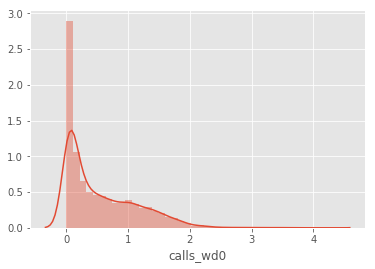

In [46]:
sns.distplot(np.log1p(df_zones.loc[df_zones_train.index,'calls_wd0']))

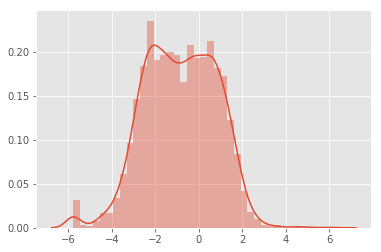

In [47]:
sns.distplot(boxcox(df_zones.loc[df_zones_train.index,'calls_wd0']+1e-16)[0])

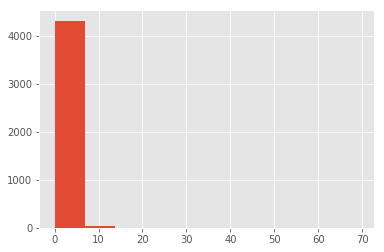

In [48]:
df_zones.loc[df_zones_train.index,'calls_wd0'].hist()

In [50]:
#(фолды по значению угла: a<60, 60<=a<120, a>=120)
def CV_by_angle(df_zones,df_features,df_zones_train,model,box_cox=True,verbose=True):
    total_score = []
    for day in range(7):
        scores = []
        if verbose:
            print('Day:', str(day))
        #I. a<60 -VAL
        X_train = df_features.loc[df_zones_train[df_zones_train.angle>=60].index, :]
        #y_train = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle>=60].index, 'calls_wd'+str(day)])
        y_train, lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle>=60].index, 'calls_wd'+str(day)]+1e-10)

        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[df_zones_train.angle<60].index, :]
        #y_val = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle<60].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle<60].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1   
        y_cros_val = invboxcox(y_cros_val,lmbda)
        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: a<60")
            print('Score: ', score)

        #II. 60<=a<120 -VAL
        X_train = df_features.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, :]
        #y_train = np.log1p(df_zones.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)])
        y_train,lmbda = boxcox(df_zones.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)]+1e-10)

        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, :]
        #y_val = np.log1p(df_zones.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1  
        y_cros_val = invboxcox(y_cros_val,lmbda)
        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: 60<=a<120")
            print( 'Score: ', score)
        
        #III. a>=120 -VAL
        X_train = df_features.loc[df_zones_train[df_zones_train.angle<120].index, :]
        #y_train = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle<120].index, 'calls_wd'+str(day)])
        y_train, lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle<120].index, 'calls_wd'+str(day)]+1e-10)
 
        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[df_zones_train.angle>=120].index, :]
        #y_val = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle>=120].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle>=120].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1
        y_cros_val = invboxcox(y_cros_val,lmbda)

        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: a>=120")
            print('Score: ', score)
            print("------------")
            print()
        total_score.append(scores)
        
    return total_score

### Добавим прогнозы VGG-16 и ResNet-50 как признаки

In [55]:
vgg_work_train = pd.read_csv("./igor_work/train_workday_vgg.csv")
vgg_weekend_train = pd.read_csv("./igor_work/train_weekend_vgg.csv")

vgg_work_box_cox_train = pd.read_csv("./igor_work/train_workday_vgg_boxcox.csv")
vgg_weekend_box_cox_train = pd.read_csv("./igor_work/train_weekend_vgg_boxcox.csv")

resnet_work_train = pd.read_csv("./igor_work/train_workday.csv")
resnet_weekend_train = pd.read_csv("./igor_work/train_weekend.csv")

resnet_work_box_cox_train = pd.read_csv("./igor_work/train_workday_nn_resnet50_boxcox_pat1.csv")
resnet_weekend_box_cox_train = pd.read_csv("./igor_work/train_weekend_nn_resnet50_boxcox_pat1.csv")

In [56]:
vgg_work_test = pd.read_csv("./igor_work/test_workday_vgg.csv")
vgg_weekend_test = pd.read_csv("./igor_work/test_weekend_vgg.csv")

vgg_work_box_cox_test = pd.read_csv("./igor_work/test_workday_vgg_boxcox.csv")
vgg_weekend_box_cox_test= pd.read_csv("./igor_work/test_weekend_vgg_boxcox.csv")

resnet_work_test = pd.read_csv("./igor_work/test_workday.csv")
resnet_weekend_test = pd.read_csv("./igor_work/test_weekend.csv")

resnet_work_box_cox_test = pd.read_csv("./igor_work/test_workday_nn_resnet50_boxcox_pat1.csv")
resnet_weekend_box_cox_test = pd.read_csv("./igor_work/test_weekend_nn_resnet50_boxcox_pat1.csv")

In [57]:
vgg_concat_train = vgg_work_train.merge(vgg_weekend_train,on="zone_id",how="inner")
vgg_concat_test = vgg_work_test.merge(vgg_weekend_test,on="zone_id",how="inner")
resnet_concat_train = resnet_work_train.merge(resnet_weekend_train,on="zone_id",how="inner")
resnet_concat_test = resnet_work_test.merge(resnet_weekend_test,on="zone_id",how="inner")

In [58]:
box_cox_vgg_concat_train = vgg_work_box_cox_train.merge(vgg_weekend_box_cox_train,on="zone_id",how="inner")
box_cox_vgg_concat_test = vgg_work_box_cox_test.merge(vgg_weekend_box_cox_test,on="zone_id",how="inner")
box_cox_resnet_concat_train = resnet_work_box_cox_train.merge(resnet_weekend_box_cox_train,on="zone_id",how="inner")
box_cox_resnet_concat_test = resnet_work_box_cox_test.merge(resnet_weekend_box_cox_test,on="zone_id",how="inner")

In [59]:
vgg_resnet_train = vgg_concat_train.merge(resnet_concat_train,on="zone_id",how="inner")
vgg_resnet_test = vgg_concat_test.merge(resnet_concat_test,on="zone_id",how="inner")

In [60]:
box_cox_vgg_resnet_train = box_cox_vgg_concat_train.merge(box_cox_resnet_concat_train,on="zone_id",how="inner")
box_cox_vgg_resnet_test = box_cox_vgg_concat_test.merge(box_cox_resnet_concat_test,on="zone_id",how="inner")

In [61]:
box_cox_vgg_and_vgg_resnet_train = vgg_resnet_train.merge(box_cox_vgg_concat_train,on="zone_id",how="inner")
box_cox_vgg_and_vgg_resnet_test= vgg_resnet_test.merge(box_cox_vgg_concat_test,on="zone_id",how="inner")

In [62]:
full_pseudo_train = box_cox_vgg_resnet_train.merge(vgg_resnet_train,on="zone_id",how="inner")
full_pseudo_test = box_cox_vgg_resnet_test.merge(vgg_resnet_test,on="zone_id",how="inner")

In [63]:
#(фолды по значению угла: a<60, 60<=a<120, a>=120) С учётом добавленных фичей из сеток
def CV_by_angle_with_pseudo(df_zones,df_features,df_zones_train,model,\
                            pseudo_labels:"concat of work and holiday days",polynom_f:bool,box_cox=True,verbose=True):

    pf=PolynomialFeatures()
    
    total_score = []
    for day in range(7):
        scores = []
        if verbose:
            print('Day:', str(day))
        #I. a<60 -VAL
        X_train = df_features.loc[df_zones_train[df_zones_train.angle>=60].index, :]
        
        X_train["zone_id"]=X_train.index
        X_train = X_train.merge(pseudo_labels,on="zone_id",how="inner")
        X_train = X_train.drop("zone_id",1)
        
        #y_train = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle>=60].index, 'calls_wd'+str(day)])
        y_train, lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle>=60].index, 'calls_wd'+str(day)]+1e-10)

        if polynom_f:
            pf.fit(X_train)
            X_train=pf.transform(X_train)
            
        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[df_zones_train.angle<60].index, :]
        
        X_val["zone_id"]=X_val.index
        X_val = X_val.merge(pseudo_labels,on="zone_id",how="inner")
        X_val = X_val.drop("zone_id",1)
        
        if polynom_f:
            X_val=pf.transform(X_val)
        
        #y_val = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle<60].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle<60].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1   
        y_cros_val = invboxcox(y_cros_val,lmbda)
        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: a<60")
            print('Score: ', score)

        #II. 60<=a<120 -VAL
        X_train = df_features.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, :]
        
        X_train["zone_id"]=X_train.index
        X_train = X_train.merge(pseudo_labels,on="zone_id",how="inner")
        X_train = X_train.drop("zone_id",1)
        
        #y_train = np.log1p(df_zones.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)])
        y_train,lmbda = boxcox(df_zones.loc[df_zones_train[~((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)]+1e-10)

        if polynom_f:
            pf.fit(X_train)
            X_train=pf.transform(X_train)
    
        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, :]
        
        X_val["zone_id"]=X_val.index
        X_val = X_val.merge(pseudo_labels,on="zone_id",how="inner")
        X_val = X_val.drop("zone_id",1)
        
        if polynom_f:
            X_val=pf.transform(X_val)

        #y_val = np.log1p(df_zones.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[((df_zones_train.angle>=60) & (df_zones_train.angle<120))].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1  
        y_cros_val = invboxcox(y_cros_val,lmbda)
        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: 60<=a<120")
            print( 'Score: ', score)
        
        #III. a>=120 -VAL
        X_train = df_features.loc[df_zones_train[df_zones_train.angle<120].index, :]
        
        X_train["zone_id"]=X_train.index
        X_train = X_train.merge(pseudo_labels,on="zone_id",how="inner")
        X_train = X_train.drop("zone_id",1)
        
        #y_train = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle<120].index, 'calls_wd'+str(day)])
        y_train, lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle<120].index, 'calls_wd'+str(day)]+1e-10)
 
        if polynom_f:
            pf.fit(X_train)
            X_train=pf.transform(X_train)
            
        model.fit(X_train, y_train)
        
        X_val = df_features.loc[df_zones_train[df_zones_train.angle>=120].index, :]
        
        X_val["zone_id"]=X_val.index
        X_val = X_val.merge(pseudo_labels,on="zone_id",how="inner")
        X_val = X_val.drop("zone_id",1)
        
        if polynom_f:
            X_val=pf.transform(X_val)

        
        #y_val = np.log1p(df_zones.loc[df_zones_train[df_zones_train.angle>=120].index, 'calls_wd'+str(day)])
        y_val,lmbda = boxcox(df_zones.loc[df_zones_train[df_zones_train.angle>=120].index, 'calls_wd'+str(day)]+1e-10)

        # вычисляем значение метрики 
        y_cros_val = model.predict(X_val)
        
        #y_cros_val = np.exp(y_cros_val) - 1
        y_cros_val = invboxcox(y_cros_val,lmbda)

        score = kendalltau(y_val, y_cros_val).correlation
        scores.append(score)
        
        if verbose:
            print("OOF: a>=120")
            print('Score: ', score)
            print("------------")
            print()
        total_score.append(scores)
        
    return total_score

# LGBM

### Feature Selection

In [64]:
#важность признаков для LGBM (в порядке возрастания)
features_lgb =np.loadtxt("lgb_feature_importance_increase_order.txt",dtype="O",delimiter="\t")
features_lgb
print(len(features_lgb))

2681


##  Hand hyperparams tuning with feature selection

In [66]:
gbm_tune = lgb.LGBMRegressor(boosting_type="dart",num_leaves=2,learning_rate=0.05,n_estimators=1000,\
                        objective="huber",subsample=0.25,colsample_by_tree=0.25)

In [69]:
%%time
l = CV_by_angle_with_pseudo(df_zones,df_features[features_lgb[-50:]],df_zones_train,polynom_f=False,pseudo_labels=vgg_resnet_train,model=gbm_tune,verbose=True)
print("Model:",gbm_tune)
print("box-cox")
print("Nans replace zeros")
print("added new features and dropped some useful features")
print("CNN labelling: VGG, ResNet")
print("50 most important fetures from feature importnace by learning on whole train set")
print("cellurar features")
print("Quality by cv:")
l = np.array(l)
print(np.mean(l,axis=1))
print(np.mean(np.mean(l,axis=1)))

Day: 0
OOF: a<60
Score:  0.6728061076618885
OOF: 60<=a<120
Score:  0.6909473544461274
OOF: a>=120
Score:  0.6835755468500486
------------

Day: 1
OOF: a<60
Score:  0.6722572439066032
OOF: 60<=a<120
Score:  0.6979384193593166
OOF: a>=120
Score:  0.6871287840515266
------------

Day: 2
OOF: a<60
Score:  0.6627403470518496
OOF: 60<=a<120
Score:  0.7073749162396851
OOF: a>=120
Score:  0.6883914739945077
------------

Day: 3
OOF: a<60
Score:  0.6755725668057057
OOF: 60<=a<120
Score:  0.7079674383601692
OOF: a>=120
Score:  0.6877470233344064
------------

Day: 4
OOF: a<60
Score:  0.6791288867180143
OOF: 60<=a<120
Score:  0.7062469650919665
OOF: a>=120
Score:  0.6943794318967793
------------

Day: 5
OOF: a<60
Score:  0.6590222132973657
OOF: 60<=a<120
Score:  0.6862054611322882
OOF: a>=120
Score:  0.6805498779838219
------------

Day: 6
OOF: a<60
Score:  0.6607025189968253
OOF: 60<=a<120
Score:  0.6823587493549503
OOF: a>=120
Score:  0.6680168995897883
------------

Model: LGBMRegressor(boosti

## LGBM
### 0.6834 - на CV


In [214]:
%%time
#c учетом камер наблюдений
l = CV_by_angle_with_pseudo(df_zones,df_features[features_lgb[-50:].tolist()+camera_yard_entrance_features],\
                            df_zones_train,polynom_f=False,pseudo_labels=vgg_resnet_train,\
                            model=gbm_tune,verbose=True)
print("Model:",gbm_tune)
print("box-cox")
print("Nans replace zeros")
print("added new features and dropped some useful features")
print("Pseudo labelling: VGG, ResNet")
print("50 most important fetures from feature importnace by learning on whole train set")
print("cellurar features")
print("camera_features")
print("Quality by cv:")
l = np.array(l)
print(np.mean(l,axis=1))
print(np.mean(np.mean(l,axis=1)))

Day: 0
OOF: a<60
Score:  0.6786501158456046
OOF: 60<=a<120
Score:  0.6889106593004345
OOF: a>=120
Score:  0.68520347964047
------------

Day: 1
OOF: a<60
Score:  0.674998869599543
OOF: 60<=a<120
Score:  0.6966032330742319
OOF: a>=120
Score:  0.6878782856121455
------------

Day: 2
OOF: a<60
Score:  0.6644551393296939
OOF: 60<=a<120
Score:  0.705249828600051
OOF: a>=120
Score:  0.6902403278679384
------------

Day: 3
OOF: a<60
Score:  0.6790951868101227
OOF: 60<=a<120
Score:  0.7044040033590402
OOF: a>=120
Score:  0.6888154415876383
------------

Day: 4
OOF: a<60
Score:  0.6806031740771227
OOF: 60<=a<120
Score:  0.7050252630060014
OOF: a>=120
Score:  0.6945817384518191
------------

Day: 5
OOF: a<60
Score:  0.6626555347548941
OOF: 60<=a<120
Score:  0.6866490557223338
OOF: a>=120
Score:  0.6809153071463079
------------

Day: 6
OOF: a<60
Score:  0.6634383367146531
OOF: 60<=a<120
Score:  0.6790370304156887
OOF: a>=120
Score:  0.6709341459507797
------------

Model: LGBMRegressor(boosting_t

In [70]:
#важность признаков lgbm с учётом постобогащения данных
t = np.loadtxt("NEW_lgb_feature_importance_increase_order.txt",dtype="O",delimiter="\t")

In [71]:
len(t)

192

In [72]:
t[-31:]

array(['transactions_boosters_mcc_5411_points_in_0.02',
       'transactions_boosters_weekday_5_points_in_0.006',
       'votes_max_dist_k_10', 'yard_camera_mean_dist_k_3',
       'highway_points_in_0.007', 'highway_bus_stop_mean_dist_k_2',
       'transactions_boosters_mcc_5912_points_in_0.006',
       'shop_hairdresser_mean_dist_k_1', 'votes_mean_dist_k_10',
       'shop_mean_dist_k_10', 'highway_mean_dist_k_10',
       'shop_mean_dist_k_3', 'shop_convenience_mean_dist_k_2',
       'amenity_pharmacy_mean_dist_k_2', 'amenity_pharmacy_mean_dist_k_3',
       'votes_max_dist_k_5',
       'transactions_boosters_mcc_5411_points_in_0.006',
       'transactions_boosters_mcc_5912_points_in_0.01',
       'shop_supermarket_mean_dist_k_2', 'yard_camera_mean_dist_k_1',
       'amenity_bank_mean_dist_k_1', 'amenity_pharmacy_mean_dist_k_5',
       'shop_mean_dist_k_21', 'highway_mean_dist_k_15',
       'shop_mean_dist_k_15', 'takeaway_yes_mean_dist_k_1',
       'transactions_boosters_weekday_6_poin

In [74]:
%%time
l = CV_by_angle_with_pseudo(df_zones,df_features[t[-31:]],\
                            df_zones_train,polynom_f=False,pseudo_labels=vgg_resnet_train,\
                            model=gbm_tune,verbose=False)
print("Model:",gbm_tune)
print("box-cox")
print("Nans replace zeros")
print("added new features and dropped some useful features")
print("Pseudo labelling: VGG, ResNet")
print("33 most important fetures from feature importnace by learning on whole train set and cameras")
print("cellurar features")
print("camera_features")
print("Quality by cv:")
l = np.array(l)
print(np.mean(l,axis=1))
print(np.mean(np.mean(l,axis=1)))

Model: LGBMRegressor(boosting_type='dart', class_weight=None, colsample_by_tree=0.25,
       colsample_bytree=1.0, learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=2, objective='huber',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.25, subsample_for_bin=200000, subsample_freq=1)
box-cox
Nans replace zeros
added new features and dropped some useful features
Pseudo labelling: VGG, ResNet
33 most important fetures from feature importnace by learning on whole train set and cameras
cellurar features
camera_features
Quality by cv:
[0.68561676 0.68987008 0.69025559 0.69419652 0.69532279 0.67900799
 0.67322038]
0.6867843014858244
CPU times: user 1min 38s, sys: 4.88 s, total: 1min 43s
Wall time: 14 s


## Делаем прогноз 

In [75]:
idx_test = df_zones.query('is_test == 1').index

In [87]:
%%time
predictions = []
for day in range(7):
    print('Day:', str(day))
    
    # учим 
    X_train = df_features.loc[df_zones_train.index, :]
    
    X_train = X_train[t[-29:]]
    X_train["zone_id"]=X_train.index
    X_train = X_train.merge(vgg_resnet_train,on="zone_id",how="inner")
    X_train = X_train.drop("zone_id",1)
    
    y_train,lmbda = boxcox(df_zones.loc[df_zones_train.index, 'calls_wd'+str(day)]+1e-10)
    gbm_tune.fit(X_train,y_train)
    X_test  = df_features.loc[idx_test, :]

    X_test = X_test[t[-29:]]    
    X_test["zone_id"]=X_test.index
    X_test = X_test.merge(vgg_resnet_test,on="zone_id",how="inner")
    X_test = X_test.drop("zone_id",1)
    
    # предсказываем и записываем 
    y_hat = gbm_tune.predict(X_test)
    y_hat = invboxcox(y_hat,lmbda)
    predictions.append(y_hat)

Day: 0
Day: 1
Day: 2
Day: 3
Day: 4
Day: 5
Day: 6
CPU times: user 55.6 s, sys: 3.01 s, total: 58.6 s
Wall time: 9.71 s


In [91]:
target_columns = ['calls_wd{}'.format(d) for d in range(7)]
df_test_predictions = pd.DataFrame(np.transpose(np.array(predictions)))
df_test_predictions.columns = target_columns
df_test_predictions['zone_id'] = idx_test
df_test_predictions = df_test_predictions[['zone_id']+target_columns]

df_test_predictions.to_csv('./submissions/best.csv')
df_test_predictions.head()


,zone_id,calls_wd0,calls_wd1,calls_wd2,calls_wd3,calls_wd4,calls_wd5,calls_wd6
0,79,0.017993,0.017975,0.017113,0.019387,0.019159,0.021155,0.022303
1,80,0.016520,0.015551,0.012191,0.015655,0.016123,0.017809,0.020421
2,81,0.013577,0.012428,0.011528,0.013141,0.013978,0.015386,0.019427
3,82,0.014914,0.014621,0.010979,0.014411,0.015672,0.015307,0.018914
4,83,0.014018,0.013131,0.010979,0.013936,0.014385,0.014490,0.018479


In [118]:
#for_frontend
pd.concat((df_test_predictions.reset_index(drop=True).drop("zone_id",1),\
           df_zones[df_zones.is_test==1][["lat_c","lon_c"]].reset_index(drop=True)),1).to_json("./front-end/dots.json",orient="records")